In [19]:
spark

# Imports

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.cloud import storage
from io import BytesIO
from datetime import datetime, date

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, BooleanType, IntegerType , DateType, FloatType, StructType, StructField
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split, dayofweek
from pyspark.sql import functions as F

# Taxi Data Frame

In [21]:
bucket_name = 'my-bigdataproject-jg'
gs_path  = f'gs://{bucket_name}/'
landing_folder = 'landing/'
cleaned_folder = 'cleaned/'
destination_folder = 'code_and_models/'

storage_client = storage.Client() 
bucket = storage_client.get_bucket(bucket_name)

In [22]:
data_years = [2021, 2022, 2023]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

taxi_file_path = gs_path + landing_folder
taxi_file_list = [taxi_file_path + f'yellow_tripdata_{year}-{month}.parquet' for year in data_years for month in months]

taxi_df = None
for file in taxi_file_list:
    df = spark.read.parquet(file)
    df = df.withColumn('VendorID', df['VendorID'].cast(IntegerType()))
    df = df.withColumn('passenger_count', df['passenger_count'].cast(IntegerType()))
    if taxi_df is None:
        taxi_df = df
    else:
        taxi_df = taxi_df.union(df)

taxi_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2021-01-01 00:30:10|  2021-01-01 00:36:12|              1|          2.1|       1.0|                 N|         142|          43|           2|        8.0|  3.0|    0.5|       0.

# Shape 

In [23]:
print(f'Number of records in the dataframe: {taxi_df.count():,}')
print(f'Number of columns in the dataframe: {len(taxi_df.columns)}')

taxi_df.printSchema()

Number of records in the dataframe: 108,870,632
Number of columns in the dataframe: 19
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



# Empty Records

In [24]:
taxi_df.select([count(when(col(c).isNull(), c)).alias(c) for c in taxi_df.columns]).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        4156354|            0|   4156354|           4156354|           0|           0|           0|          0|    0|      0|         

# RatecodeID

In [25]:
taxi_df.groupBy('RatecodeID').count().show()

+----------+--------+
|RatecodeID|   count|
+----------+--------+
|      NULL| 4156354|
|       1.0|99557949|
|      99.0|  358812|
|       6.0|     619|
|       5.0|  673528|
|       2.0| 3671238|
|       4.0|  163244|
|       3.0|  288888|
+----------+--------+



# passenger_count

In [26]:
taxi_df.select('passenger_count').summary().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|         104714278|
|   mean|1.3976889665418883|
| stddev|0.9597532957271568|
|    min|                 0|
|    25%|                 1|
|    50%|                 1|
|    75%|                 1|
|    max|               112|
+-------+------------------+



In [27]:
taxi_df.groupBy('passenger_count').count().show()

+---------------+--------+
|passenger_count|   count|
+---------------+--------+
|           NULL| 4156354|
|              1|77584327|
|              6| 1228388|
|              3| 4102273|
|              4| 1965358|
|              5| 1887328|
|              2|15895315|
|              7|     395|
|              0| 2050304|
|              9|     138|
|              8|     450|
|            112|       1|
|             96|       1|
+---------------+--------+



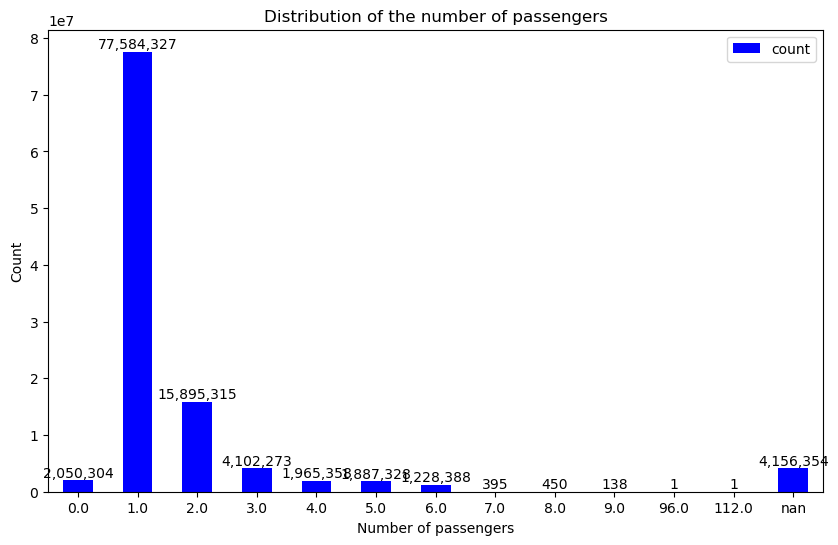

In [8]:
# Create a histogram of the passenger_count column to show the distribution of the number of passengers
passenger_count_df = taxi_df.groupBy('passenger_count').count().toPandas()
passenger_count_df = passenger_count_df.sort_values(by='passenger_count')
passenger_count_df.plot(kind='bar', x='passenger_count', y='count', color='blue', figsize=(10, 6))
plt.title('Distribution of the number of passengers')
plt.xlabel('Number of passengers')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, count in enumerate(passenger_count_df['count']):
    plt.text(i, count, f'{count:,}', ha='center', va='bottom')

plt.show()


# trip_distance

In [28]:
taxi_df.select('trip_distance').summary().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|        108870632|
|   mean|5.574651813539291|
| stddev|538.2452378045958|
|    min|              0.0|
|    25%|             1.09|
|    50%|             1.82|
|    75%|             3.43|
|    max|        389678.46|
+-------+-----------------+



In [29]:
long_trips_df = taxi_df.filter(taxi_df['trip_distance'] >= 50)
long_trips_df.select('trip_distance').summary().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|             20044|
|   mean|11872.112096387946|
| stddev|37851.042603395355|
|    min|              50.0|
|    25%|             55.23|
|    50%|             65.75|
|    75%|             115.2|
|    max|         389678.46|
+-------+------------------+



In [30]:
short_trips_df = taxi_df.filter(taxi_df['trip_distance'] <= 3)
short_trips_df.select('trip_distance').summary().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|          77315601|
|   mean|1.4388492215172612|
| stddev|0.7168069611523155|
|    min|               0.0|
|    25%|               0.9|
|    50%|              1.37|
|    75%|              1.96|
|    max|               3.0|
+-------+------------------+



In [31]:
print(f'Number of trips with a distance of 0 miles: {taxi_df.filter(taxi_df["trip_distance"] == 0).count()}')
print(f'Number of trips with a distance greater than 45 miles: {taxi_df.filter(taxi_df["trip_distance"] >= 45).count()}')
print(f'Number of trips with a distance greater than 60 miles: {taxi_df.filter(taxi_df["trip_distance"] >= 60).count()}')
print(f'Number of trips with a distance greater than 75 miles: {taxi_df.filter(taxi_df["trip_distance"] >= 75).count()}')
print(f'Number of trips with a distance greater than 100 miles: {taxi_df.filter(taxi_df["trip_distance"] >= 100).count()}')

Number of trips with a distance of 0 miles: 1755328


Number of trips with a distance greater than 45 miles: 27307


Number of trips with a distance greater than 60 miles: 12297


Number of trips with a distance greater than 75 miles: 7904


Number of trips with a distance greater than 100 miles: 5592


# fare_amount

In [32]:
taxi_df.select('fare_amount').summary().show()

+-------+------------------+
|summary|       fare_amount|
+-------+------------------+
|  count|         108870632|
|   mean|14.481928569871213|
| stddev|13476.234731681256|
|    min|     -1.33391414E8|
|    25%|               7.5|
|    50%|              11.0|
|    75%|              18.0|
|    max|         818283.44|
+-------+------------------+



In [33]:
# Create a fare amount data frame with only positive fare amounts
positive_fare_amount_df = taxi_df.filter(taxi_df['fare_amount'] >= 3)
positive_fare_amount_df.select('fare_amount', 'tip_amount').summary().show()

+-------+------------------+------------------+
|summary|       fare_amount|        tip_amount|
+-------+------------------+------------------+
|  count|         107721215|         107721215|
|   mean|16.402927855861513|2.9319876673319407|
| stddev|120.83707963951639|3.5116601517863373|
|    min|               3.0|            -16.47|
|    25%|               7.5|              0.93|
|    50%|              11.4|              2.26|
|    75%|              18.4|              3.69|
|    max|         818283.44|            4174.0|
+-------+------------------+------------------+



In [34]:
# Large fare amount data frame
large_fare_amount_df = taxi_df.filter(taxi_df['fare_amount'] >= 250)
large_fare_amount_df.select('fare_amount', 'tip_amount').summary().show()

+-------+------------------+------------------+
|summary|       fare_amount|        tip_amount|
+-------+------------------+------------------+
|  count|             14456|             14456|
|   mean| 593.9716553680134|20.714244604316555|
| stddev|10334.019557619235|31.409967432699055|
|    min|             250.0|               0.0|
|    25%|             263.4|               0.0|
|    50%|             300.0|               0.0|
|    75%|             350.0|             47.25|
|    max|         818283.44|           1140.44|
+-------+------------------+------------------+



# tip_amount

In [35]:
taxi_df.select('tip_amount').summary().show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|         108870632|
|   mean| 4.539324010813152|
| stddev|13475.692319792852|
|    min|            -411.0|
|    25%|              0.01|
|    50%|              2.26|
|    75%|              3.66|
|    max|    1.3339136353E8|
+-------+------------------+



In [36]:
positive_tip_amount_df = taxi_df.filter(taxi_df['tip_amount'] >= 0)
positive_tip_amount_df.select('tip_amount').summary().show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|         108862802|
|   mean|4.5399068747100815|
| stddev|13476.176932543343|
|    min|               0.0|
|    25%|              0.01|
|    50%|              2.26|
|    75%|              3.66|
|    max|    1.3339136353E8|
+-------+------------------+



In [37]:
# large tip amount data frame
large_tip_amount_df = taxi_df.filter(taxi_df['tip_amount'] >= 150)
large_tip_amount_df.select('tip_amount').summary().show()


+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|               753|
|   mean| 236440.6163612218|
| stddev|5121942.3195773745|
|    min|             150.0|
|    25%|            168.15|
|    50%|             200.0|
|    75%|             260.0|
|    max|    1.3339136353E8|
+-------+------------------+



# tip_percent

In [38]:
taxi_df = taxi_df.withColumn('tip_percentage', taxi_df['tip_amount'] / taxi_df['fare_amount'])
taxi_df.select('tip_percentage').summary().show() 

+-------+-------------------+
|summary|     tip_percentage|
+-------+-------------------+
|  count|          108827121|
|   mean|0.21847584634010997|
| stddev| 14.189951925461827|
|    min|-108.39999999999999|
|    25%|            0.00125|
|    50%|0.23897435897435898|
|    75%| 0.2930232558139535|
|    max|            50000.0|
+-------+-------------------+



In [39]:
# get the positive tip percentage data frame
positive_tip_percentage_df = taxi_df.filter(taxi_df['tip_percentage'] > 0)
positive_tip_percentage_df.select('tip_percentage').summary().show()

+-------+------------------+
|summary|    tip_percentage|
+-------+------------------+
|  count|          81694366|
|   mean|0.2910840788545534|
| stddev|16.377063001725695|
|    min|            2.0E-5|
|    25%|           0.22125|
|    50%|         0.2646875|
|    75%|              0.31|
|    max|           50000.0|
+-------+------------------+



# total_amount

In [40]:
taxi_df.select('total_amount').summary().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|         108870632|
|   mean| 23.50020369106584|
| stddev|120.85273704035589|
|    min|           -2567.8|
|    25%|             12.96|
|    50%|              17.3|
|    75%|             25.56|
|    max|         818286.74|
+-------+------------------+



In [41]:
positive_total_amount_df = taxi_df.filter(taxi_df['total_amount'] > 3)
positive_total_amount_df.select('total_amount').summary().show()


+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|         108051649|
|   mean|23.831366233332023|
| stddev|121.22998662299418|
|    min|              3.01|
|    25%|             12.96|
|    50%|              17.5|
|    75%|             25.56|
|    max|         818286.74|
+-------+------------------+



In [42]:
# get the large total amount data frame
large_total_amount_df = taxi_df.filter(taxi_df['total_amount'] >= 400)
large_total_amount_df.select('total_amount', 'fare_amount', 'tip_amount').summary().show()

+-------+------------------+------------------+------------------+
|summary|      total_amount|       fare_amount|        tip_amount|
+-------+------------------+------------------+------------------+
|  count|              3703|              3703|              3703|
|   mean|1536.1020199837972|1480.7822198217657| 36.39009181744531|
| stddev|20394.826123429222|20394.255632448454|110.82424630703134|
|    min|             400.0|               0.0|               0.0|
|    25%|            422.89|             380.0|               0.0|
|    50%|             466.0|             420.9|               0.0|
|    75%|            523.86|             500.0|              67.4|
|    max|         818286.74|         818283.44|            4174.0|
+-------+------------------+------------------+------------------+



# Date Time

In [43]:
# Check the min and max dates for the two columns: tpep_pickup_datetime and tpep_dropoff_datetime
taxi_df.select(F.min('tpep_pickup_datetime'), F.max('tpep_pickup_datetime')).show()
taxi_df.select(F.min('tpep_dropoff_datetime'), F.max('tpep_dropoff_datetime')).show()

# Only keep the records within the date range: 2021-01-01 to 2024-01-01

taxi_df = taxi_df.filter((col('tpep_pickup_datetime') >= '2021-01-01') & (col('tpep_pickup_datetime') < '2024-01-01'))
taxi_df = taxi_df.filter((col('tpep_dropoff_datetime') >= '2021-01-01') & (col('tpep_dropoff_datetime') < '2024-01-01'))

# Check the min and max dates for the two columns: tpep_pickup_datetime and tpep_dropoff_datetime
taxi_df.select(F.min('tpep_pickup_datetime'), F.max('tpep_pickup_datetime')).show()
taxi_df.select(F.min('tpep_dropoff_datetime'), F.max('tpep_dropoff_datetime')).show()


+-------------------------+-------------------------+
|min(tpep_pickup_datetime)|max(tpep_pickup_datetime)|
+-------------------------+-------------------------+
|      2001-01-01 00:03:14|      2098-09-11 02:23:31|
+-------------------------+-------------------------+



+--------------------------+--------------------------+
|min(tpep_dropoff_datetime)|max(tpep_dropoff_datetime)|
+--------------------------+--------------------------+
|       1970-01-20 10:16:32|       2098-09-11 02:52:04|
+--------------------------+--------------------------+



+-------------------------+-------------------------+
|min(tpep_pickup_datetime)|max(tpep_pickup_datetime)|
+-------------------------+-------------------------+
|      2021-01-01 00:00:04|      2023-12-31 23:57:46|
+-------------------------+-------------------------+



+--------------------------+--------------------------+
|min(tpep_dropoff_datetime)|max(tpep_dropoff_datetime)|
+--------------------------+--------------------------+
|       2021-01-01 00:01:02|       2023-12-31 23:59:56|
+--------------------------+--------------------------+



# Number of trips

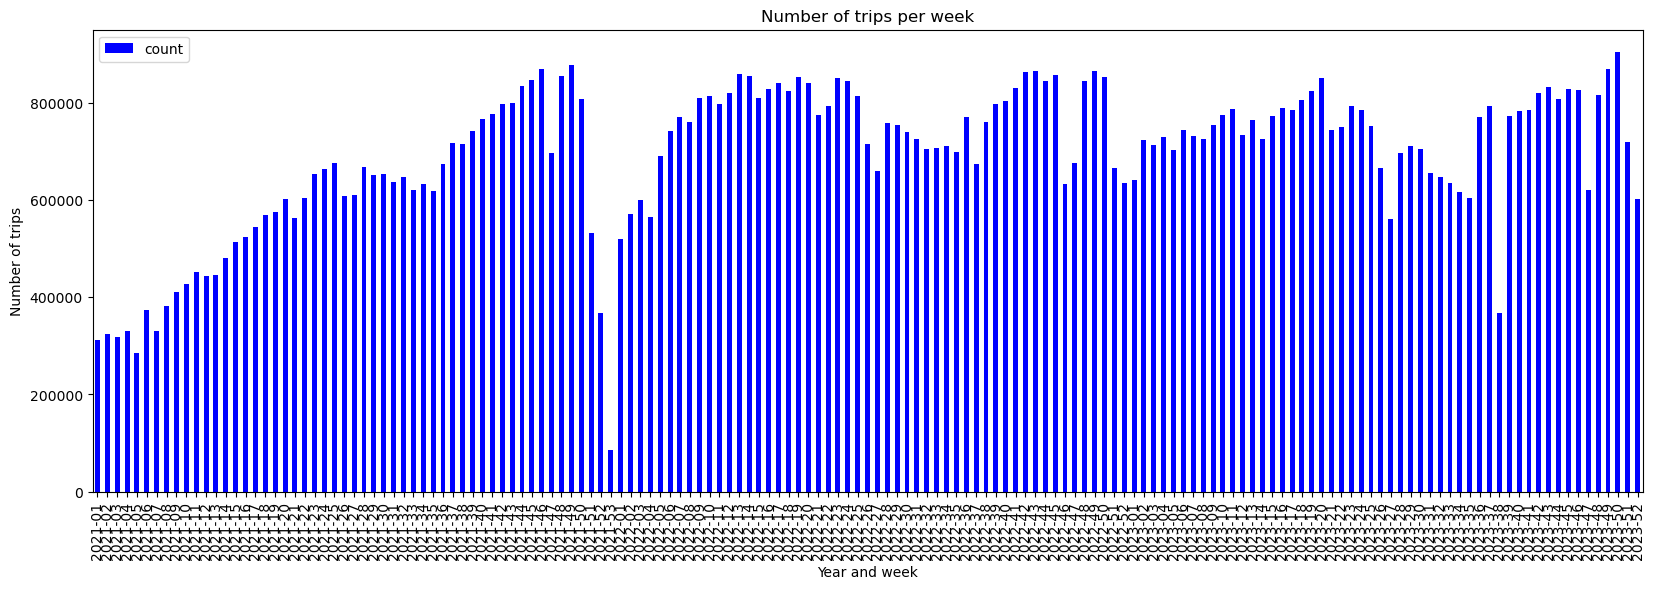

In [27]:
# Create a new date column
# Using the tpep_pickup_datetime column, create a new column week_of_year which is the week of the year
# Then create a new column year_week which is the year and week combined
# It should be the week number and year combined, e.g. 2023-01
taxi_df = taxi_df.withColumn('week_of_year', F.weekofyear('tpep_pickup_datetime'))
taxi_df = taxi_df.withColumn('year_week', F.concat(F.year('tpep_pickup_datetime'), F.lit('-'), F.lpad('week_of_year', 2, '0')))

# Create a graph showing the number of trips per week
trips_per_week_df = taxi_df.groupBy('year_week').count().toPandas()
trips_per_week_df = trips_per_week_df.sort_values(by='year_week')
trips_per_week_df.plot(kind='bar', x='year_week', y='count', color='blue', figsize=(20, 6))
plt.title('Number of trips per week')
plt.xlabel('Year and week')
plt.ylabel('Number of trips')
plt.xticks(rotation=90)

plt.show()

